In [202]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [203]:
# First let's load the data and take a look at the first few rows. 

#Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/timshilstone/marketing_analysis/main/Customer_Segmentation/Data/online12M.csv"
download = requests.get(url).content


# Reading the downloaded content and turning it into a pandas Dataframe

online = pd.read_csv(io.StringIO(download.decode('utf-8')))


# Printing out the first 5 rows of the Dataframe.

online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [ ]:
# Each row in this dataset corresponds to one transaction made by a customer between Dec 2010 and Dec 2011

#### Creating RFM Dataframe

In [204]:
# Next we'll create a new column that calculates the total amount spent for each transaction.

In [205]:
online['TotalSum'] = online.Quantity * online.UnitPrice

In [206]:
# Then we'll convert InvoiceDate to a datetime object so we can perform calculations on it.

In [207]:
online['InvoiceDate'] = pd.to_datetime(online.InvoiceDate)

In [208]:
# Here we create a snapshot date, a point in time used to calculate the customer recency.

In [209]:
snapshot_date = online.InvoiceDate.max() + dt.timedelta(days=1)
snapshot_date = pd.to_datetime(snapshot_date)

In [210]:
# Then we group all the transactions by CustomerID and calculate the number of days since the most recent purchase, 
# the number of transactions, and the total amount spent by each customer.

In [211]:
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

In [212]:
# Then we rename these columns appropriately.

In [213]:
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

In [214]:
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


#### Creating Custom Segments

In [215]:
# First we want to split each column into 4 quartiles based on their value. For Recency, we want to asign a higher 
# score for a lower value (ie the more recent a customer purchased with us the better they are) and a higher score
# for a higher value for Frequency and MonetaryValue (ie the more frequent a customer spends and the more they spend
# the better they are)

In [216]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

In [217]:
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(datamart['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

In [218]:
# Then we'll create new columns to hold their corresponding scores.

In [219]:
datamart = datamart.assign(R=r_groups.values, F=f_groups.values,M=m_groups.values)

In [220]:
# Let's also create column that represents the three scores concatenated together. This can be useful for selecting 
# specific RFM_Segments.

In [221]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

In [222]:
datamart['RFM_Segment'] = datamart.apply(join_rfm,axis=1)

In [223]:
# Finally we'll create a RFM score which will be the sum of their R,F and M columns.

In [224]:
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [225]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,3,25,948.70,4,4,4,4.04.04.0,12
12748,1,888,7046.16,4,4,4,4.04.04.0,12
12749,4,37,813.45,4,4,4,4.04.04.0,12
12820,4,17,268.02,4,3,3,4.03.03.0,10
12822,71,9,146.15,2,2,3,2.02.03.0,7


In [226]:
# To categorize the customers we can bucket them into Gold, Silver and Bronze groups based on their score.

In [227]:
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Gold'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Silver'
    else:
        return 'Bronze'

In [228]:
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

In [229]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12747,3,25,948.70,4,4,4,4.04.04.0,12,Gold
12748,1,888,7046.16,4,4,4,4.04.04.0,12,Gold
12749,4,37,813.45,4,4,4,4.04.04.0,12,Gold
12820,4,17,268.02,4,3,3,4.03.03.0,10,Gold
12822,71,9,146.15,2,2,3,2.02.03.0,7,Silver


#### Analyzing RFM Table Segments

In [230]:
# Taking a quick look at the custom groups shows us they are fairly evenly split.

In [231]:
Level = datamart.groupby('RFM_Level').size()
Level = Level.reindex(index = ['Gold','Silver','Bronze'])
Level

RFM_Level
Gold      1021
Silver    1547
Bronze    1075
dtype: int64

In [232]:
# And looking at unique RFM_Segment sizes shows a good distribution. 

In [233]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
4.04.04.0    372
1.01.01.0    345
2.01.01.0    169
3.04.04.0    156
2.03.03.0    129
2.02.02.0    128
3.03.03.0    120
1.02.02.0    117
3.01.01.0    114
4.03.03.0    113
dtype: int64

In [234]:
# Grouping customers by RFM_Score shows our grouping has worked as intended. 

In [235]:
datamart.groupby('RFM_Score').agg({'Recency': 'mean', 'Frequency': 'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           246.9       2.1          28.4   345
4           162.2       3.1          47.8   337
5           138.9       4.3          78.2   393
6           101.0       6.3         146.3   444
7            78.0       8.5         160.2   382
8            62.6      12.8         196.3   376
9            46.8      16.7         330.3   345
10           31.9      24.0         443.1   355
11           21.8      38.9         705.3   294
12            8.0      75.6        1653.9   372

In [236]:
# Same goes for our custom segments

In [237]:
Leveldf = datamart.groupby('RFM_Level').agg({'Recency': 'mean', 'Frequency': 'mean','MonetaryValue':['mean','count']}).round(1)
Leveldf = Leveldf.reindex(index = ['Gold','Silver','Bronze'])
Leveldf

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Gold         20.3      47.1         959.7  1021
Silver       73.9      10.7         202.9  1547
Bronze      180.8       3.2          52.7  1075

#### Data Preprocessing for K-Means Segmentation

In [238]:
# Next we're going to segment customers using the K-Means clustering algorithm. To get started we want to create 
# a new dataframe called datamart_rfm that just contatins the Recency, Frequency, and MonetaryValue columns.

In [239]:
datamart_rfm = datamart[['Recency','Frequency','MonetaryValue']]

In [240]:
# First let's take a look at the skewedness of the data. 
# As you can see below the data is quite skewed to the right.

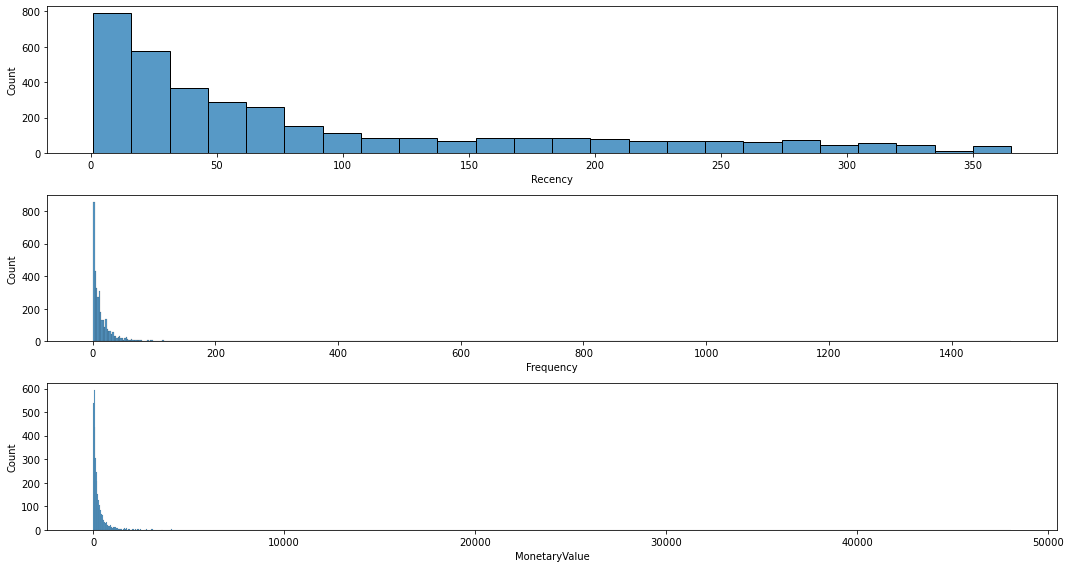

In [241]:
fig, ax = plt.subplots(figsize=(15,8))
plt.subplot(3, 1, 1); sns.histplot(datamart_rfm['Recency'])
plt.subplot(3, 1, 2); sns.histplot(datamart_rfm['Frequency'])
plt.subplot(3, 1, 3); sns.histplot(datamart_rfm['MonetaryValue'])
plt.tight_layout()
plt.show()

In [242]:
# Let's perform a log calculation on the dataframe to remove skewedness.

In [243]:
datamart_rfm_log = np.log(datamart_rfm)

In [244]:
# As you can see the data is looking much more even now.

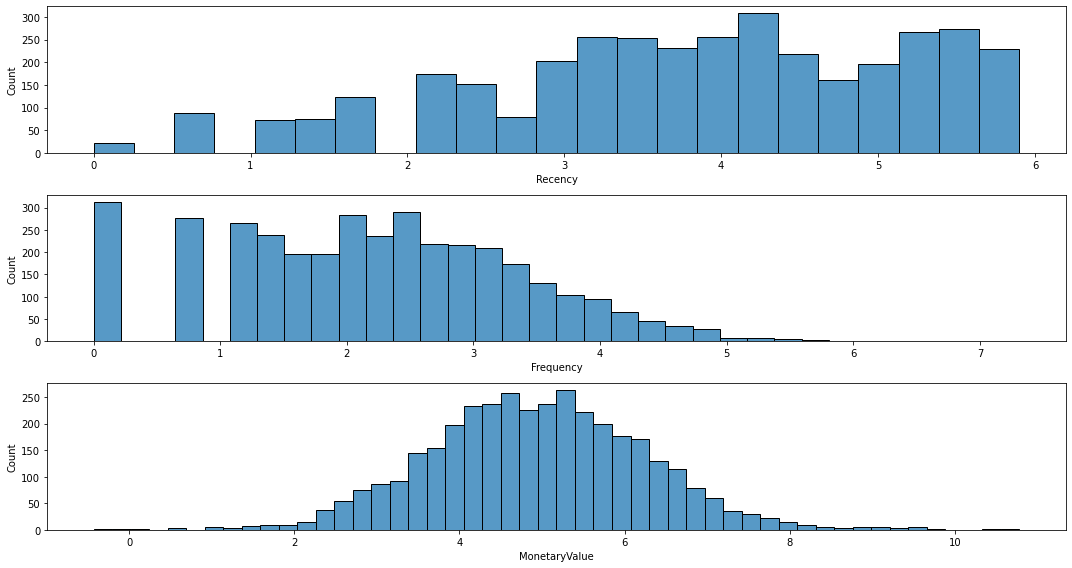

In [245]:
fig, ax = plt.subplots(figsize=(15,8))
plt.subplot(3, 1, 1); sns.histplot(datamart_rfm_log['Recency'])
plt.subplot(3, 1, 2); sns.histplot(datamart_rfm_log['Frequency'])
plt.subplot(3, 1, 3); sns.histplot(datamart_rfm_log['MonetaryValue'])
plt.tight_layout()
plt.show()

In [246]:
# Next let's look at the mean and standard deviation foreach variable. 
# This shows us that the data needs to be normalized as they are very different values. 
# K means clustering doesn't work well with numbers like this.

In [247]:
datamart_rfm_log.describe()

,Recency,Frequency,MonetaryValue
count,3643.000000,3643.000000,3643.000000
mean,3.806481,2.171902,4.934900
std,1.352631,1.210321,1.310945
min,0.000000,0.000000,-0.430783
25%,2.944439,1.386294,4.072524
50%,3.931826,2.197225,4.915372
75%,4.934474,3.044522,5.812188
max,5.899897,7.311218,10.780213


In [248]:
# To center the mean values we need to perform a simple calculation with a Scikit-Learn preprocessing package.

In [249]:
scaler = StandardScaler()
scaler.fit(datamart_rfm_log)
datamart_normalized = scaler.transform(datamart_rfm_log)

In [250]:
# Below shows that the normalization of the data worked. Both the mean and std are now equal across columns.

In [251]:
datamart_normalized_df = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [252]:
datamart_normalized_df.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3643.00,3643.00,3643.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.81,-1.79,-4.09
25%,-0.64,-0.65,-0.66
50%,0.09,0.02,-0.01
75%,0.83,0.72,0.67
max,1.55,4.25,4.46


In [253]:
# And this visualizes the same results.

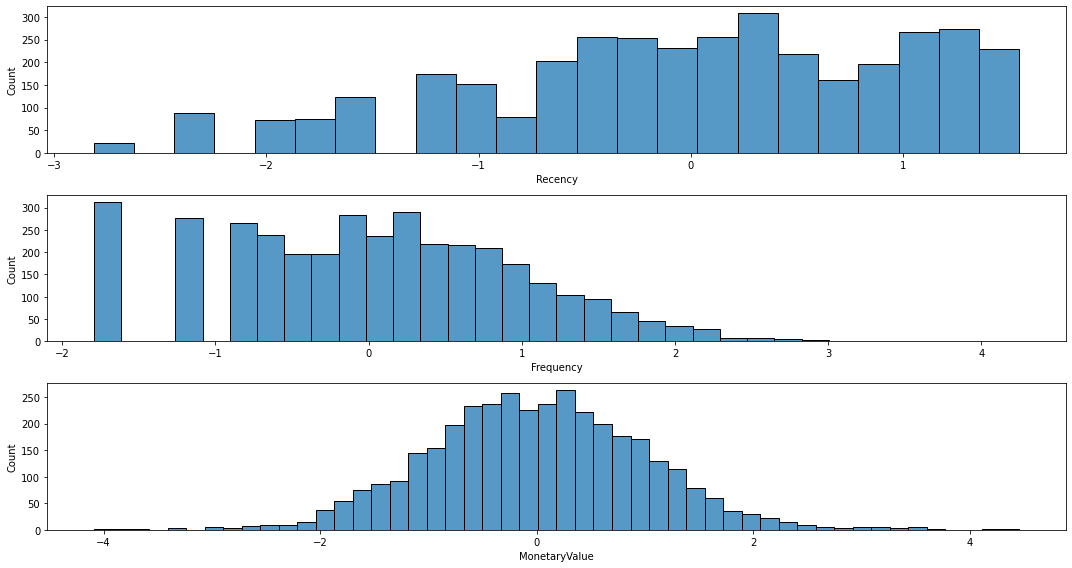

In [254]:
fig, ax = plt.subplots(figsize=(15,8))
plt.subplot(3, 1, 1); sns.histplot(datamart_normalized_df['Recency'])
plt.subplot(3, 1, 2); sns.histplot(datamart_normalized_df['Frequency'])
plt.subplot(3, 1, 3); sns.histplot(datamart_normalized_df['MonetaryValue'])
plt.tight_layout()
plt.show()

In [255]:
# Great now we're ready to cluster our customers into unique segments!

### Creating Customer Clusters

In [256]:
# First we need to find out how many clusters to create. To do this we'll create a simple for loop to discover what 
# number is best for our business needs before encountering deminishing returns.

In [257]:
# Let's instantiate the model with different values for n_clusters and fit it to our normalized data. The result is
# a dictionary of n_clusters values from 1 - 10 and their SSE values (sum of sqr distances to closest cluster center)

#### Deciding Number of Clusters

In [258]:
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ 

In [259]:
# Let's plot the results with k values on the x axis and SSE on the y axis.
# The general rule of thumb is to choose the k value at the point in the chart with the sharpest angel. In this case,
# we'd choose 2 clusters. We should also compare this to 3 to see if that could be more useful for our business.

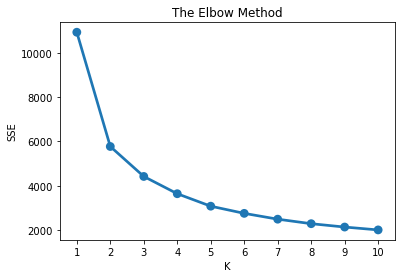

In [260]:
plt.title('The Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

In [261]:
# Now let's take a look at the results for both 2 and 3 clusters side by side. First we instantiate the model
# with 2 clusters and fit it to our normalized data.

In [262]:
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(datamart_normalized)

KMeans(n_clusters=2, random_state=1)

In [263]:
# Then we'll extract the labels from the result, create a new dataframe called datamart_rfm_k2, and add the 
# cluster labels as a column to the original Dataframe. 

In [264]:
cluster_labels = kmeans.labels_
datamart_rfm_k2 = datamart_rfm.assign(Cluster=cluster_labels)
grouped_k2 = datamart_rfm_k2.groupby(['Cluster'])

In [ ]:
# We'll repeat this process for 3 n_clusters

In [265]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)
grouped_k3 = datamart_rfm_k3.groupby(['Cluster'])

In [266]:
# Finally let's take a look at how these clusters differ from one another.

In [268]:
grouped_k2.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         137.3       5.3          91.9  2024
1          31.9      35.4         719.2  1619

In [267]:
grouped_k3.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.6       3.1          53.5  1180
1          15.7      50.3        1059.3   889
2          77.1      12.6         219.5  1574

#### Snake Plot Analysis

In [269]:
# Another way to understand how the indiviudal clusters differ is to plot a snake plot. This can make it easier to 
# quickly understand how the segments differ from one another. First we add the cluster columns.

In [270]:
datamart_normalized_df['Cluster'] = datamart_rfm_k3['Cluster']

In [271]:
# Then we melt the name of the columns into one column and their values saved to another. This allows us to plot the 
# data to a line chart with the metrics on the x axis and their values to the y axis.

In [272]:
datamart_melt = pd.melt(datamart_normalized_df.reset_index(), id_vars=['CustomerID', 'Cluster'], 
                        value_vars=['Frequency', 'MonetaryValue', 'Recency'],
                        var_name='Attribute', value_name='Value')

In [ ]:
# Then we plot the results.

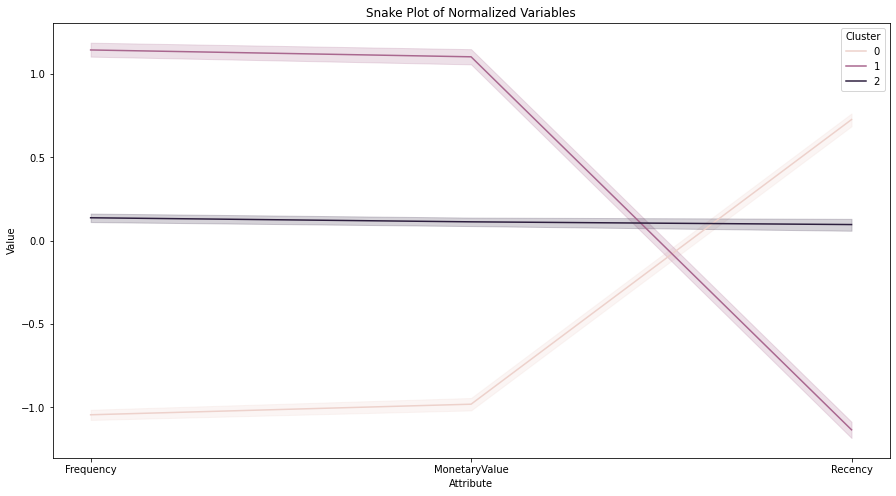

In [273]:
fig,ax = plt.subplots(figsize=(15,8))
plt.title('Snake Plot of Normalized Variables')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.lineplot(data=datamart_melt, x='Attribute', y='Value', hue='Cluster')
plt.show()

#### Calculating Relative Importance of Each Attribute

In [274]:
# Awesome. These clusters look very distinct from one another. 
# Now let's understand the relative importance of each Metric.

In [275]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0           0.82      -0.84          -0.86
1          -0.83       1.69           1.86
2          -0.15      -0.33          -0.41


In [276]:
# Let's plot this as a heatmap for better interpretation. The further away an attributes relative importance score is
# from 0 the more important that attribute is for defining the cluster compared to the population average.

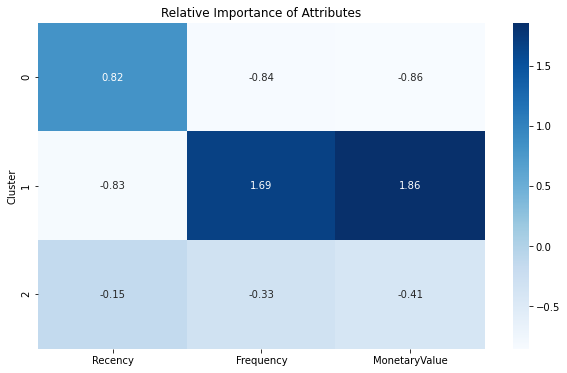

In [277]:
plt.figure(figsize=(10,6))
plt.title('Relative Importance of Attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues')
plt.show()